In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.2
2023-06-04 07:48:13.613927


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 48
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-12.6418)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(3.9616)
penalty_target_min tensor(-12.3191) penalty_target_max tensor(6.1955)
train_loss:  -10.310355686950682
valid_loss:  -9.590500329589842
h_min_tilde -12.319111 ell_tilde -10.166384615478515 kappa_tilde 0.0006815623571347406


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 6.955891847610474

 2 6.960354566574097

 3 6.303440093994141

 4 6.696429967880249

 5 6.72080659866333

 6 6.911710023880005

 7 3.099241018295288

 8 3.359656810760498

 9 3.1883039474487305

 10 6.70228385925293

 11 6.708980560302734

 12 6.784863710403442

 13 6.75584602355957

 14 6.6986167430877686

 15 6.417147874832153

 16 6.699558258056641

 17 6.643466472625732

 18 3.9438138008117676

 19 3.3703999519348145

 20 3.0953807830810547

 21 3.22101092338562

 22 3.29557728767395

 23 3.4657320976257324

 24 3.6399056911468506

 25 3.74971866607666

 26 3.6988439559936523

 27 3.457644462585449

 28 3.4529407024383545

 29 3.5771892070770264

 30 3.444851875305176

 31 3.7492098808288574

 32 3.61112380027771

 33 3.6459310054779053

 34 3.4921560287475586

 35 3.528920888900757

 36 3.5376505851745605

 37 3.5427958965301514

 38 3.5725691318511963

 39 3.618293285369873

 40 3.564330816268921

 41 3.557249069213867

 42 3.531043529510498

 43 3.5205607414245605

 44 3.606

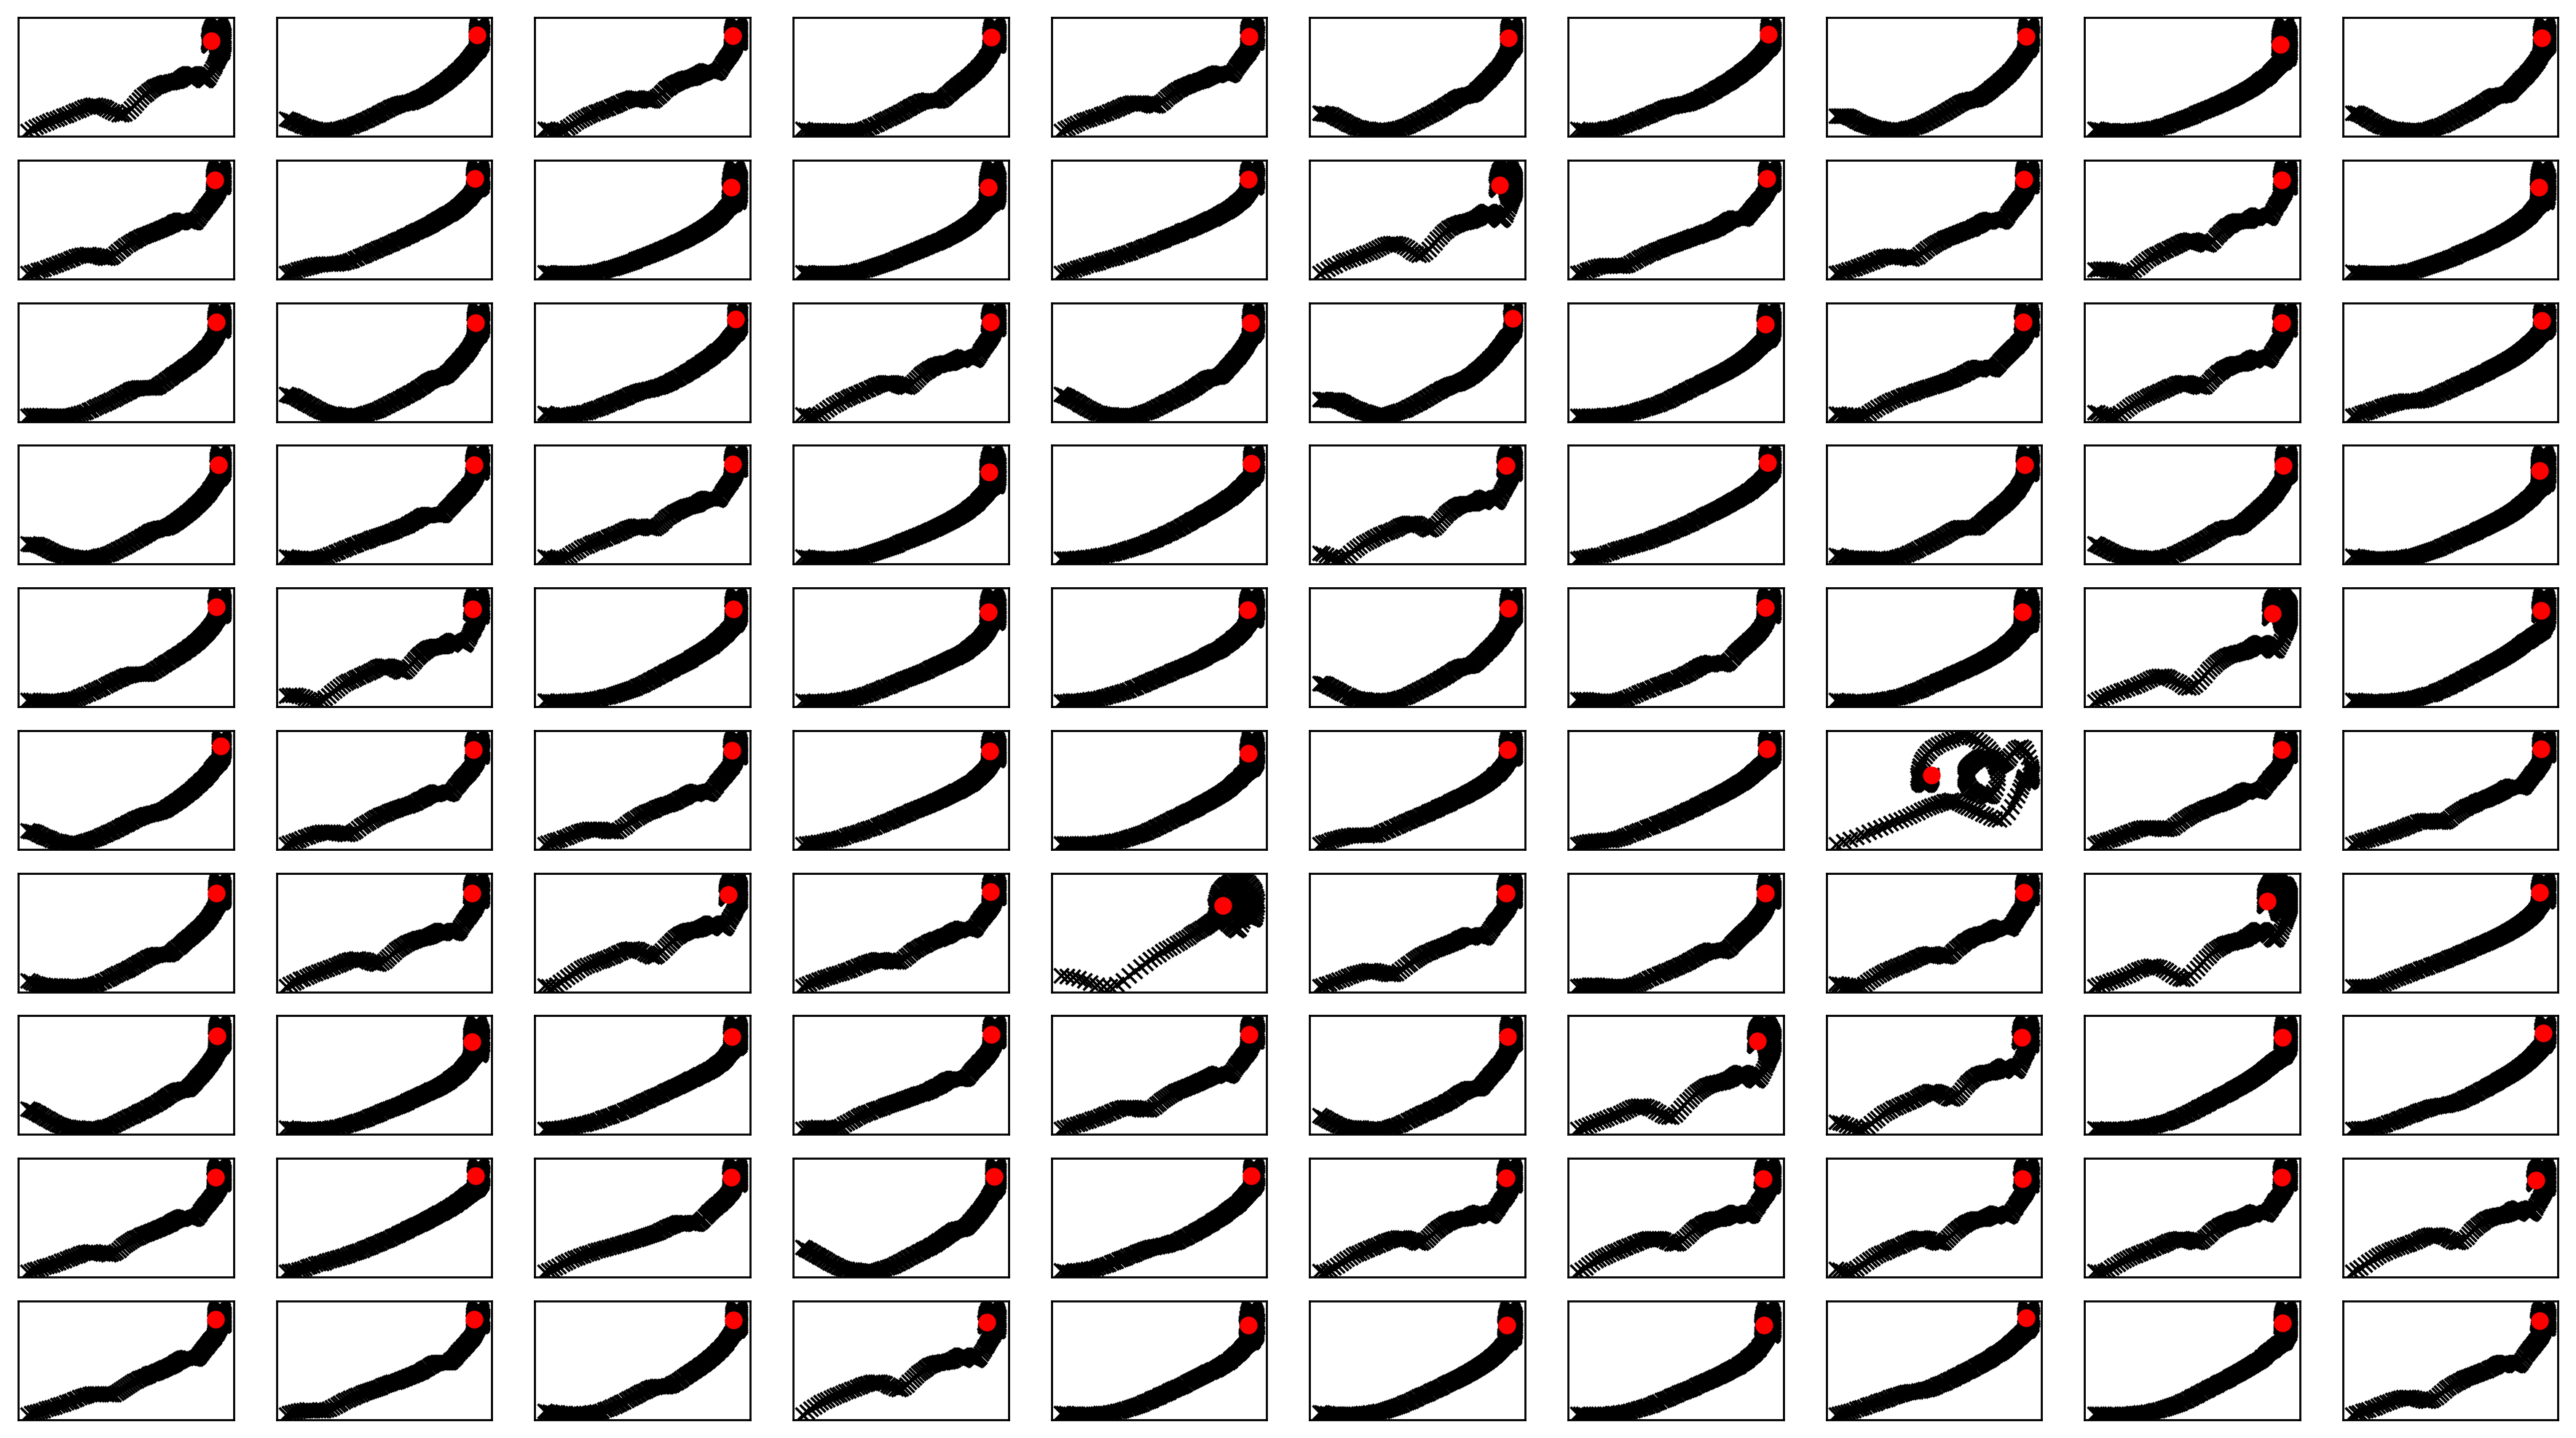

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

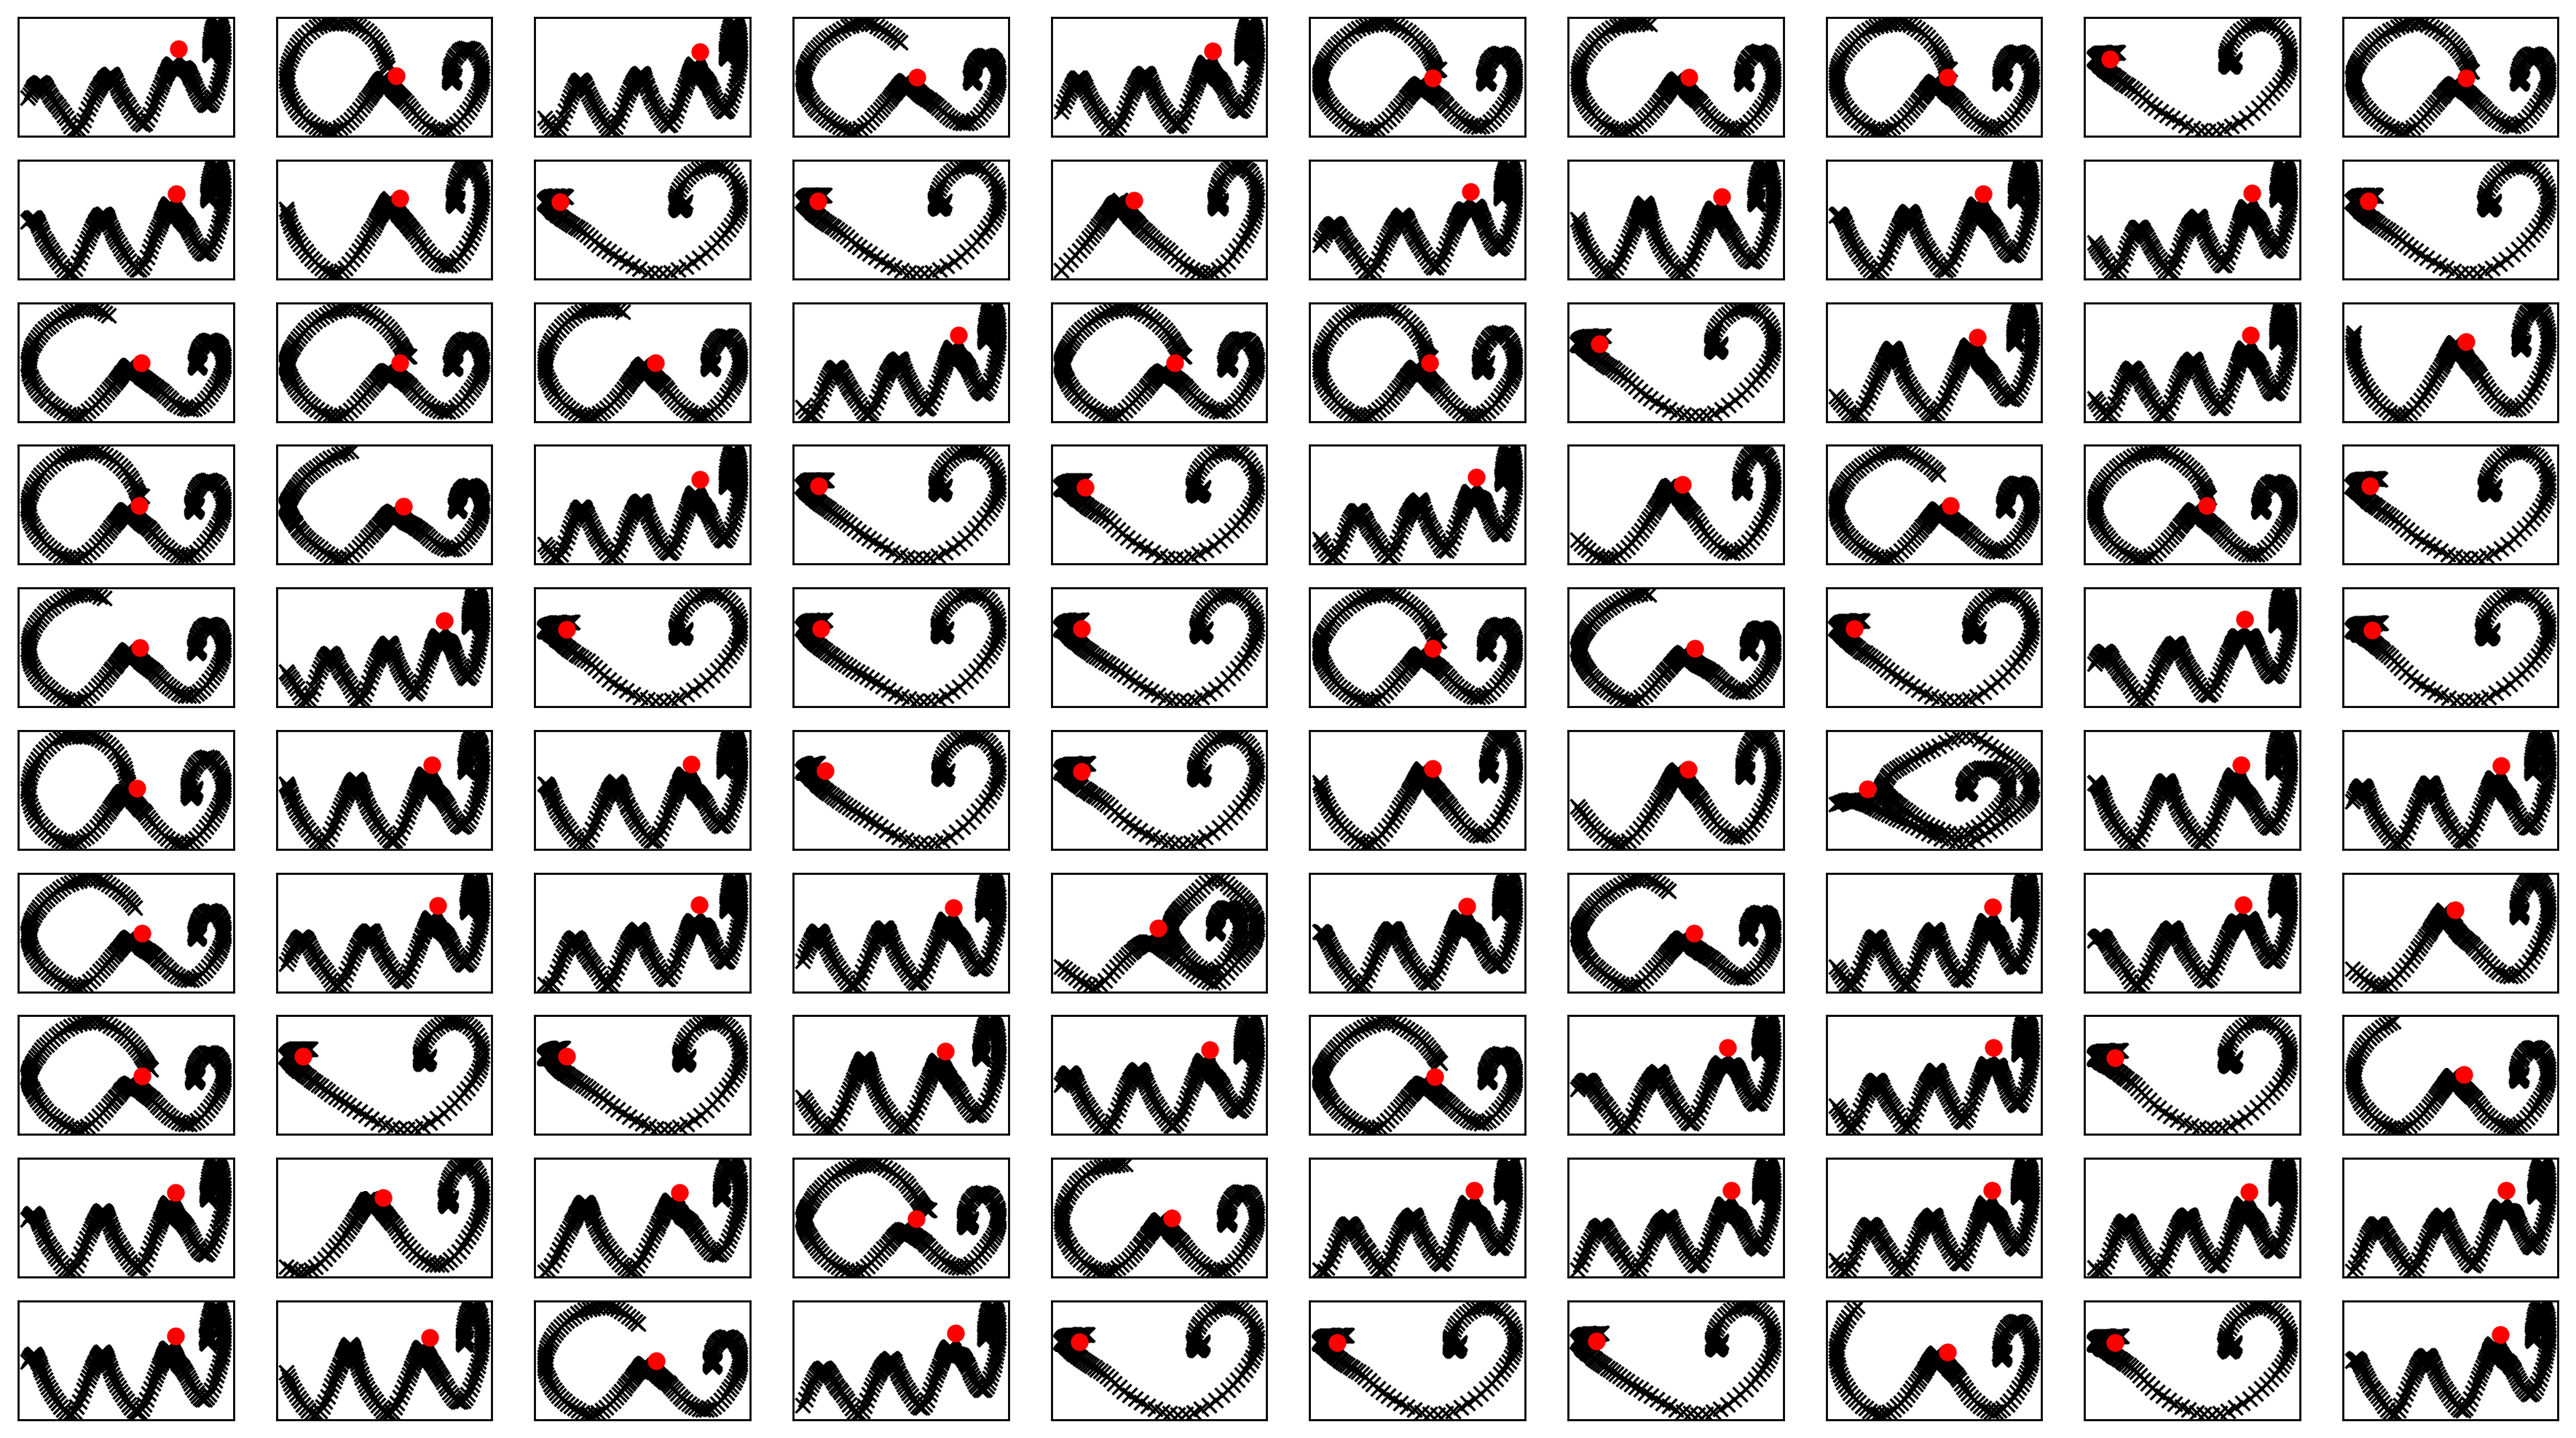

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-06-04 07:54:57.098743


# Iter 1

In [9]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [10]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.39813  validloss 1.45832±0.00000  bestvalidloss 1.45832  last_update 0
train: iter 1  trainloss 1.33161  validloss 1.33706±0.00000  bestvalidloss 1.33706  last_update 0
train: iter 2  trainloss 1.28345  validloss 1.28531±0.00000  bestvalidloss 1.28531  last_update 0
train: iter 3  trainloss 1.24316  validloss 1.25271±0.00000  bestvalidloss 1.25271  last_update 0
train: iter 4  trainloss 1.20187  validloss 1.21050±0.00000  bestvalidloss 1.21050  last_update 0
train: iter 5  trainloss 1.15631  validloss 1.17635±0.00000  bestvalidloss 1.17635  last_update 0
train: iter 6  trainloss 1.09962  validloss 1.11973±0.00000  bestvalidloss 1.11973  last_update 0
train: iter 7  trainloss 1.02993  validloss 1.05327±0.00000  bestvalidloss 1.05327  last_update 0
train: iter 8  trainloss 0.97907  validloss 1.00947±0.00000  bestvalidloss 1.00947  last_update 0
train: iter 9  trainloss 0.93670  validloss 0.95080±0.00000  bestvalidloss 0.95080  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.66793  validloss 0.74186±0.00000  bestvalidloss 0.71419  last_update 9
train: iter 84  trainloss 0.66962  validloss 0.72094±0.00000  bestvalidloss 0.71419  last_update 10
train: iter 85  trainloss 0.66889  validloss 0.73017±0.00000  bestvalidloss 0.71419  last_update 11
train: iter 86  trainloss 0.67856  validloss 0.73195±0.00000  bestvalidloss 0.71419  last_update 12
train: iter 87  trainloss 0.67863  validloss 0.74212±0.00000  bestvalidloss 0.71419  last_update 13
train: iter 88  trainloss 0.68166  validloss 0.71988±0.00000  bestvalidloss 0.71419  last_update 14
train: iter 89  trainloss 0.67654  validloss 0.72097±0.00000  bestvalidloss 0.71419  last_update 15
train: iter 90  trainloss 0.67148  validloss 0.73147±0.00000  bestvalidloss 0.71419  last_update 16
train: iter 91  trainloss 0.66295  validloss 0.71923±0.00000  bestvalidloss 0.71419  last_update 17
train: iter 92  trainloss 0.66689  validloss 0.72153±0.00000  bestvalidloss 0.71419  last_update 18
t

train: iter 165  trainloss 0.60837  validloss 0.68723±0.00000  bestvalidloss 0.68415  last_update 8
train: iter 166  trainloss 0.61240  validloss 0.71047±0.00000  bestvalidloss 0.68415  last_update 9
train: iter 167  trainloss 0.60111  validloss 0.71132±0.00000  bestvalidloss 0.68415  last_update 10
train: iter 168  trainloss 0.60976  validloss 0.71360±0.00000  bestvalidloss 0.68415  last_update 11
train: iter 169  trainloss 0.60510  validloss 0.69390±0.00000  bestvalidloss 0.68415  last_update 12
train: iter 170  trainloss 0.60736  validloss 0.68793±0.00000  bestvalidloss 0.68415  last_update 13
train: iter 171  trainloss 0.61775  validloss 0.72247±0.00000  bestvalidloss 0.68415  last_update 14
train: iter 172  trainloss 0.60579  validloss 0.69127±0.00000  bestvalidloss 0.68415  last_update 15
train: iter 173  trainloss 0.60283  validloss 0.72340±0.00000  bestvalidloss 0.68415  last_update 16
train: iter 174  trainloss 0.60866  validloss 0.70371±0.00000  bestvalidloss 0.68415  last_up

train: iter 247  trainloss 0.57045  validloss 0.65934±0.00000  bestvalidloss 0.65266  last_update 2
train: iter 248  trainloss 0.56917  validloss 0.66346±0.00000  bestvalidloss 0.65266  last_update 3
train: iter 249  trainloss 0.55559  validloss 0.66318±0.00000  bestvalidloss 0.65266  last_update 4
train: iter 250  trainloss 0.56765  validloss 0.66863±0.00000  bestvalidloss 0.65266  last_update 5
train: iter 251  trainloss 0.56514  validloss 0.68766±0.00000  bestvalidloss 0.65266  last_update 6
train: iter 252  trainloss 0.56714  validloss 0.66587±0.00000  bestvalidloss 0.65266  last_update 7
train: iter 253  trainloss 0.56536  validloss 0.65752±0.00000  bestvalidloss 0.65266  last_update 8
train: iter 254  trainloss 0.55729  validloss 0.66853±0.00000  bestvalidloss 0.65266  last_update 9
train: iter 255  trainloss 0.56677  validloss 0.66004±0.00000  bestvalidloss 0.65266  last_update 10
train: iter 256  trainloss 0.58164  validloss 0.64598±0.00000  bestvalidloss 0.64598  last_update 0

train: iter 329  trainloss 0.53812  validloss 0.63485±0.00000  bestvalidloss 0.62169  last_update 26
train: iter 330  trainloss 0.53882  validloss 0.65111±0.00000  bestvalidloss 0.62169  last_update 27
train: iter 331  trainloss 0.53581  validloss 0.64645±0.00000  bestvalidloss 0.62169  last_update 28
train: iter 332  trainloss 0.53646  validloss 0.63924±0.00000  bestvalidloss 0.62169  last_update 29
train: iter 333  trainloss 0.52945  validloss 0.64527±0.00000  bestvalidloss 0.62169  last_update 30
train: iter 334  trainloss 0.53143  validloss 0.65113±0.00000  bestvalidloss 0.62169  last_update 31
train: iter 335  trainloss 0.53933  validloss 0.62807±0.00000  bestvalidloss 0.62169  last_update 32
train: iter 336  trainloss 0.53668  validloss 0.66234±0.00000  bestvalidloss 0.62169  last_update 33
train: iter 337  trainloss 0.53183  validloss 0.63479±0.00000  bestvalidloss 0.62169  last_update 34
train: iter 338  trainloss 0.52975  validloss 0.65693±0.00000  bestvalidloss 0.62169  last_

train: iter 412  trainloss 0.50863  validloss 0.63586±0.00000  bestvalidloss 0.60925  last_update 33
train: iter 413  trainloss 0.51135  validloss 0.64027±0.00000  bestvalidloss 0.60925  last_update 34
train: iter 414  trainloss 0.50894  validloss 0.63608±0.00000  bestvalidloss 0.60925  last_update 35
train: iter 415  trainloss 0.51068  validloss 0.61506±0.00000  bestvalidloss 0.60925  last_update 36
train: iter 416  trainloss 0.51232  validloss 0.62665±0.00000  bestvalidloss 0.60925  last_update 37
train: iter 417  trainloss 0.51132  validloss 0.64588±0.00000  bestvalidloss 0.60925  last_update 38
train: iter 418  trainloss 0.50815  validloss 0.65053±0.00000  bestvalidloss 0.60925  last_update 39
train: iter 419  trainloss 0.51341  validloss 0.61799±0.00000  bestvalidloss 0.60925  last_update 40
train: iter 420  trainloss 0.51084  validloss 0.61672±0.00000  bestvalidloss 0.60925  last_update 41
train: iter 421  trainloss 0.51360  validloss 0.63120±0.00000  bestvalidloss 0.60925  last_

train: iter 494  trainloss 0.48971  validloss 0.60430±0.00000  bestvalidloss 0.60312  last_update 30
train: iter 495  trainloss 0.49343  validloss 0.60003±0.00000  bestvalidloss 0.60003  last_update 0
train: iter 496  trainloss 0.49321  validloss 0.60425±0.00000  bestvalidloss 0.60003  last_update 1
train: iter 497  trainloss 0.49312  validloss 0.60759±0.00000  bestvalidloss 0.60003  last_update 2
train: iter 498  trainloss 0.49655  validloss 0.61025±0.00000  bestvalidloss 0.60003  last_update 3
train: iter 499  trainloss 0.48984  validloss 0.62640±0.00000  bestvalidloss 0.60003  last_update 4
train: iter 500  trainloss 0.49478  validloss 0.60636±0.00000  bestvalidloss 0.60003  last_update 5
train: iter 501  trainloss 0.48768  validloss 0.61636±0.00000  bestvalidloss 0.60003  last_update 6
train: iter 502  trainloss 0.49156  validloss 0.60383±0.00000  bestvalidloss 0.60003  last_update 7
train: iter 503  trainloss 0.49169  validloss 0.64196±0.00000  bestvalidloss 0.60003  last_update 8

train: iter 576  trainloss 0.47827  validloss 0.60592±0.00000  bestvalidloss 0.59383  last_update 57
train: iter 577  trainloss 0.48067  validloss 0.62105±0.00000  bestvalidloss 0.59383  last_update 58
train: iter 578  trainloss 0.47168  validloss 0.59704±0.00000  bestvalidloss 0.59383  last_update 59
train: iter 579  trainloss 0.47017  validloss 0.60934±0.00000  bestvalidloss 0.59383  last_update 60
train: iter 580  trainloss 0.48278  validloss 0.65163±0.00000  bestvalidloss 0.59383  last_update 61
train: iter 581  trainloss 0.47840  validloss 0.62395±0.00000  bestvalidloss 0.59383  last_update 62
train: iter 582  trainloss 0.47819  validloss 0.61867±0.00000  bestvalidloss 0.59383  last_update 63
train: iter 583  trainloss 0.47448  validloss 0.60784±0.00000  bestvalidloss 0.59383  last_update 64
train: iter 584  trainloss 0.47211  validloss 0.60718±0.00000  bestvalidloss 0.59383  last_update 65
train: iter 585  trainloss 0.47248  validloss 0.61493±0.00000  bestvalidloss 0.59383  last_

([1.3981340065598489,
  1.3316088244318962,
  1.283449449390173,
  1.2431577824056148,
  1.2018652498722076,
  1.1563106298446655,
  1.0996160551905632,
  1.0299278892576695,
  0.979067225009203,
  0.9366964094340802,
  0.9040069848299026,
  0.8829387295991182,
  0.8551908455789089,
  0.8434552133083344,
  0.8264143992215395,
  0.807079927623272,
  0.814277483895421,
  0.8000749826431275,
  0.7899476766586304,
  0.7789760738611221,
  0.7709882471710443,
  0.7657778851687909,
  0.7582011971622705,
  0.7590236894786357,
  0.7595386948436499,
  0.7472612366080285,
  0.7479131948202848,
  0.7459538847208023,
  0.7405860755592585,
  0.7382183045148849,
  0.73690563775599,
  0.7231001663953066,
  0.7356250546872616,
  0.7289195422083139,
  0.7177543856203557,
  0.7232068214565516,
  0.7264723226428031,
  0.7151062689721585,
  0.7210193362087012,
  0.7195712395012379,
  0.711567860841751,
  0.7183927359059453,
  0.7171849936246872,
  0.7181998025625944,
  0.7064737264066935,
  0.7088857479393

In [11]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.859733622437715
valid_loss:  -8.128584367728234
weight_alpha 1.0 h_min_tilde -12.319111 ell_tilde -4.7135037714958194 kappa_tilde 0.00036260438927908346
train_loss:  -4.34265710477829
valid_loss:  -4.298098514556885
weight_alpha 0.2 h_min_tilde -12.319111 ell_tilde -4.333745386734009 kappa_tilde 0.0003538772151239606


In [12]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -842.75728  validloss -857.48813±0.00000  bestvalidloss -857.48813  last_update 0
train: iter 1  trainloss -850.01158  validloss -824.64706±0.00000  bestvalidloss -857.48813  last_update 1
train: iter 2  trainloss -856.69629  validloss -840.36703±0.00000  bestvalidloss -857.48813  last_update 2
train: iter 3  trainloss -854.85425  validloss -857.25456±0.00000  bestvalidloss -857.48813  last_update 3
train: iter 4  trainloss -849.58240  validloss -847.34057±0.00000  bestvalidloss -857.48813  last_update 4
train: iter 5  trainloss -843.25638  validloss -834.43451±0.00000  bestvalidloss -857.48813  last_update 5
train: iter 6  trainloss -841.07250  validloss -802.86465±0.00000  bestvalidloss -857.48813  last_update 6
train: iter 7  trainloss -856.39928  validloss -846.79234±0.00000  bestvalidloss -857.48813  last_update 7
train: iter 8  trainloss -851.06877  validloss -834.88110±0.00000  bestvalidloss -857.48813  last_u

train: iter 75  trainloss -857.97661  validloss -827.79695±0.00000  bestvalidloss -857.48813  last_update 75
train: iter 76  trainloss -851.98600  validloss -837.61591±0.00000  bestvalidloss -857.48813  last_update 76
train: iter 77  trainloss -841.94000  validloss -840.81146±0.00000  bestvalidloss -857.48813  last_update 77
train: iter 78  trainloss -847.03777  validloss -821.68860±0.00000  bestvalidloss -857.48813  last_update 78
train: iter 79  trainloss -851.19446  validloss -827.08012±0.00000  bestvalidloss -857.48813  last_update 79
train: iter 80  trainloss -859.39969  validloss -823.98567±0.00000  bestvalidloss -857.48813  last_update 80
train: iter 81  trainloss -854.21961  validloss -817.40432±0.00000  bestvalidloss -857.48813  last_update 81
train: iter 82  trainloss -850.30783  validloss -803.20288±0.00000  bestvalidloss -857.48813  last_update 82
train: iter 83  trainloss -853.97703  validloss -822.95817±0.00000  bestvalidloss -857.48813  last_update 83
train: iter 84  tra

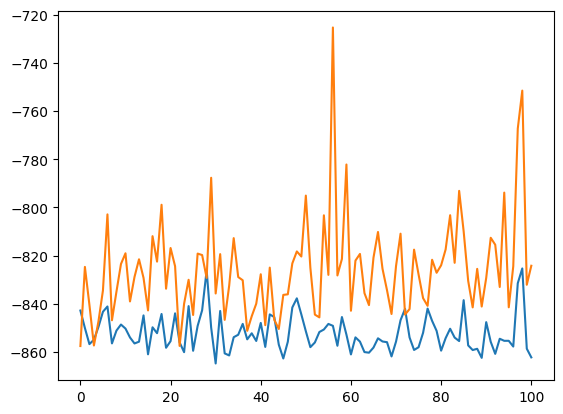

alpha 0.2 default_lr 0.0005


In [13]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [14]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [15]:
print(datetime.datetime.now())

2023-06-04 08:17:47.308557


# Iter2

In [16]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [17]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.57728  validloss 0.77899±0.00000  bestvalidloss 0.77899  last_update 0
train: iter 1  trainloss 0.56323  validloss 0.64948±0.00000  bestvalidloss 0.64948  last_update 0
train: iter 2  trainloss 0.55861  validloss 0.67035±0.00000  bestvalidloss 0.64948  last_update 1
train: iter 3  trainloss 0.54630  validloss 0.64781±0.00000  bestvalidloss 0.64781  last_update 0
train: iter 4  trainloss 0.54504  validloss 0.64728±0.00000  bestvalidloss 0.64728  last_update 0
train: iter 5  trainloss 0.54138  validloss 0.65195±0.00000  bestvalidloss 0.64728  last_update 1
train: iter 6  trainloss 0.54359  validloss 0.64104±0.00000  bestvalidloss 0.64104  last_update 0
train: iter 7  trainloss 0.54236  validloss 0.65435±0.00000  bestvalidloss 0.64104  last_update 1
train: iter 8  trainloss 0.54606  validloss 0.66690±0.00000  bestvalidloss 0.64104  last_update 2
train: iter 9  trainloss 0.53279  validloss 0.66807±0.00000  bestvalidloss 0.64104  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.49972  validloss 0.63403±0.00000  bestvalidloss 0.62963  last_update 42
train: iter 84  trainloss 0.50487  validloss 0.62441±0.00000  bestvalidloss 0.62441  last_update 0
train: iter 85  trainloss 0.50143  validloss 0.64787±0.00000  bestvalidloss 0.62441  last_update 1
train: iter 86  trainloss 0.49941  validloss 0.63933±0.00000  bestvalidloss 0.62441  last_update 2
train: iter 87  trainloss 0.49837  validloss 0.63743±0.00000  bestvalidloss 0.62441  last_update 3
train: iter 88  trainloss 0.50333  validloss 0.63708±0.00000  bestvalidloss 0.62441  last_update 4
train: iter 89  trainloss 0.49429  validloss 0.63453±0.00000  bestvalidloss 0.62441  last_update 5
train: iter 90  trainloss 0.49962  validloss 0.63217±0.00000  bestvalidloss 0.62441  last_update 6
train: iter 91  trainloss 0.49791  validloss 0.65049±0.00000  bestvalidloss 0.62441  last_update 7
train: iter 92  trainloss 0.49467  validloss 0.63094±0.00000  bestvalidloss 0.62441  last_update 8
train: it

train: iter 165  trainloss 0.48507  validloss 0.64754±0.00000  bestvalidloss 0.62253  last_update 8
train: iter 166  trainloss 0.47745  validloss 0.63596±0.00000  bestvalidloss 0.62253  last_update 9
train: iter 167  trainloss 0.48573  validloss 0.63878±0.00000  bestvalidloss 0.62253  last_update 10
train: iter 168  trainloss 0.48070  validloss 0.66883±0.00000  bestvalidloss 0.62253  last_update 11
train: iter 169  trainloss 0.47404  validloss 0.63198±0.00000  bestvalidloss 0.62253  last_update 12
train: iter 170  trainloss 0.47486  validloss 0.62402±0.00000  bestvalidloss 0.62253  last_update 13
train: iter 171  trainloss 0.47691  validloss 0.63271±0.00000  bestvalidloss 0.62253  last_update 14
train: iter 172  trainloss 0.47680  validloss 0.62591±0.00000  bestvalidloss 0.62253  last_update 15
train: iter 173  trainloss 0.47532  validloss 0.61966±0.00000  bestvalidloss 0.61966  last_update 0
train: iter 174  trainloss 0.47143  validloss 0.62490±0.00000  bestvalidloss 0.61966  last_upd

train: iter 247  trainloss 0.46385  validloss 0.62179±0.00000  bestvalidloss 0.61765  last_update 36
train: iter 248  trainloss 0.45955  validloss 0.63422±0.00000  bestvalidloss 0.61765  last_update 37
train: iter 249  trainloss 0.47275  validloss 0.63393±0.00000  bestvalidloss 0.61765  last_update 38
train: iter 250  trainloss 0.47559  validloss 0.64244±0.00000  bestvalidloss 0.61765  last_update 39
train: iter 251  trainloss 0.46455  validloss 0.64191±0.00000  bestvalidloss 0.61765  last_update 40
train: iter 252  trainloss 0.45994  validloss 0.63797±0.00000  bestvalidloss 0.61765  last_update 41
train: iter 253  trainloss 0.46171  validloss 0.63189±0.00000  bestvalidloss 0.61765  last_update 42
train: iter 254  trainloss 0.46587  validloss 0.62702±0.00000  bestvalidloss 0.61765  last_update 43
train: iter 255  trainloss 0.46798  validloss 0.62464±0.00000  bestvalidloss 0.61765  last_update 44
train: iter 256  trainloss 0.45709  validloss 0.62224±0.00000  bestvalidloss 0.61765  last_

train: iter 329  trainloss 0.45283  validloss 0.62764±0.00000  bestvalidloss 0.61285  last_update 18
train: iter 330  trainloss 0.45475  validloss 0.63827±0.00000  bestvalidloss 0.61285  last_update 19
train: iter 331  trainloss 0.45221  validloss 0.61928±0.00000  bestvalidloss 0.61285  last_update 20
train: iter 332  trainloss 0.45092  validloss 0.63062±0.00000  bestvalidloss 0.61285  last_update 21
train: iter 333  trainloss 0.45049  validloss 0.61428±0.00000  bestvalidloss 0.61285  last_update 22
train: iter 334  trainloss 0.45061  validloss 0.60684±0.00000  bestvalidloss 0.60684  last_update 0
train: iter 335  trainloss 0.44918  validloss 0.64996±0.00000  bestvalidloss 0.60684  last_update 1
train: iter 336  trainloss 0.45022  validloss 0.62901±0.00000  bestvalidloss 0.60684  last_update 2
train: iter 337  trainloss 0.45048  validloss 0.63206±0.00000  bestvalidloss 0.60684  last_update 3
train: iter 338  trainloss 0.44646  validloss 0.62631±0.00000  bestvalidloss 0.60684  last_upda

train: iter 411  trainloss 0.44395  validloss 0.62494±0.00000  bestvalidloss 0.60684  last_update 77
train: iter 412  trainloss 0.44372  validloss 0.63944±0.00000  bestvalidloss 0.60684  last_update 78
train: iter 413  trainloss 0.44182  validloss 0.63632±0.00000  bestvalidloss 0.60684  last_update 79
train: iter 414  trainloss 0.44578  validloss 0.64567±0.00000  bestvalidloss 0.60684  last_update 80
train: iter 415  trainloss 0.43803  validloss 0.61105±0.00000  bestvalidloss 0.60684  last_update 81
train: iter 416  trainloss 0.44814  validloss 0.62053±0.00000  bestvalidloss 0.60684  last_update 82
train: iter 417  trainloss 0.44086  validloss 0.62716±0.00000  bestvalidloss 0.60684  last_update 83
train: iter 418  trainloss 0.44126  validloss 0.61769±0.00000  bestvalidloss 0.60684  last_update 84
train: iter 419  trainloss 0.44062  validloss 0.62756±0.00000  bestvalidloss 0.60684  last_update 85
train: iter 420  trainloss 0.44094  validloss 0.63946±0.00000  bestvalidloss 0.60684  last_

([0.5772775478661061,
  0.5632311401888728,
  0.5586123786866665,
  0.5462974129244685,
  0.5450361676514148,
  0.541379963234067,
  0.5435912931337953,
  0.542356799915433,
  0.546063426695764,
  0.5327935256063938,
  0.5327451948076487,
  0.5349165081977845,
  0.5329253952950239,
  0.5360570449382067,
  0.5293204333633185,
  0.5357639510184526,
  0.5413572952151299,
  0.5295281510800123,
  0.526417669467628,
  0.5269664963707328,
  0.530493008159101,
  0.5275175541639328,
  0.5281488575041294,
  0.527223383821547,
  0.5273993890732527,
  0.5256318736821413,
  0.5204216884449124,
  0.5223408415913582,
  0.5208021156489849,
  0.5248953053727746,
  0.5231439493596554,
  0.5206172201782465,
  0.5198561325669289,
  0.5268919186666607,
  0.5156320547685027,
  0.5186447093263269,
  0.5160389054566622,
  0.5175823448225856,
  0.5242682363837957,
  0.5169753251597285,
  0.5204644231125712,
  0.5146267931908369,
  0.5220058389008045,
  0.5156595343723893,
  0.5078839434310793,
  0.515452047996

In [18]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.70910067641139
valid_loss:  -9.152095824396609
weight_alpha 1.0 h_min_tilde -12.317376 ell_tilde -5.597699706008434 kappa_tilde 0.00038576766240876854
train_loss:  -4.5420269444465635
valid_loss:  -4.3788785461425785
weight_alpha 0.2 h_min_tilde -12.317376 ell_tilde -4.5093972647857665 kappa_tilde 0.00035787444314048725


In [19]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -884.34181  validloss -876.28945±0.00000  bestvalidloss -876.28945  last_update 0
train: iter 1  trainloss -903.31494  validloss -872.79144±0.00000  bestvalidloss -876.28945  last_update 1
train: iter 2  trainloss -891.11038  validloss -835.63290±0.00000  bestvalidloss -876.28945  last_update 2
train: iter 3  trainloss -887.31649  validloss -867.24072±0.00000  bestvalidloss -876.28945  last_update 3
train: iter 4  trainloss -899.05065  validloss -855.79926±0.00000  bestvalidloss -876.28945  last_update 4
train: iter 5  trainloss -899.68502  validloss -884.97758±0.00000  bestvalidloss -884.97758  last_update 0
train: iter 6  trainloss -894.79315  validloss -860.69349±0.00000  bestvalidloss -884.97758  last_update 1
train: iter 7  trainloss -883.41957  validloss -851.85714±0.00000  bestvalidloss -884.97758  last_update 2
train: iter 8  trainloss -891.59563  validloss -888.10307±0.00000  bestvalidloss -888.10307  last_u

train: iter 76  trainloss -868.20374  validloss -838.88203±0.00000  bestvalidloss -888.10307  last_update 68
train: iter 77  trainloss -894.76031  validloss -859.94849±0.00000  bestvalidloss -888.10307  last_update 69
train: iter 78  trainloss -883.12924  validloss -815.44710±0.00000  bestvalidloss -888.10307  last_update 70
train: iter 79  trainloss -886.70953  validloss -854.48351±0.00000  bestvalidloss -888.10307  last_update 71
train: iter 80  trainloss -889.75258  validloss -871.70400±0.00000  bestvalidloss -888.10307  last_update 72
train: iter 81  trainloss -881.84329  validloss -861.97533±0.00000  bestvalidloss -888.10307  last_update 73
train: iter 82  trainloss -874.52769  validloss -840.12776±0.00000  bestvalidloss -888.10307  last_update 74
train: iter 83  trainloss -836.36251  validloss -811.30803±0.00000  bestvalidloss -888.10307  last_update 75
train: iter 84  trainloss -887.68366  validloss -841.95187±0.00000  bestvalidloss -888.10307  last_update 76
train: iter 85  tra

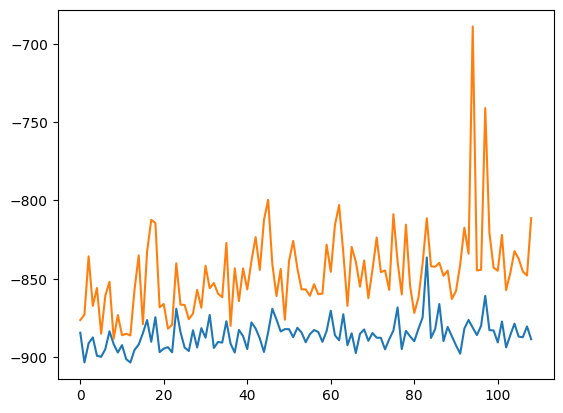

alpha 0.2 default_lr 0.0005


In [20]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [21]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [22]:
print(datetime.datetime.now())

2023-06-04 08:38:35.193697


Text(0, 0.5, 'loss')

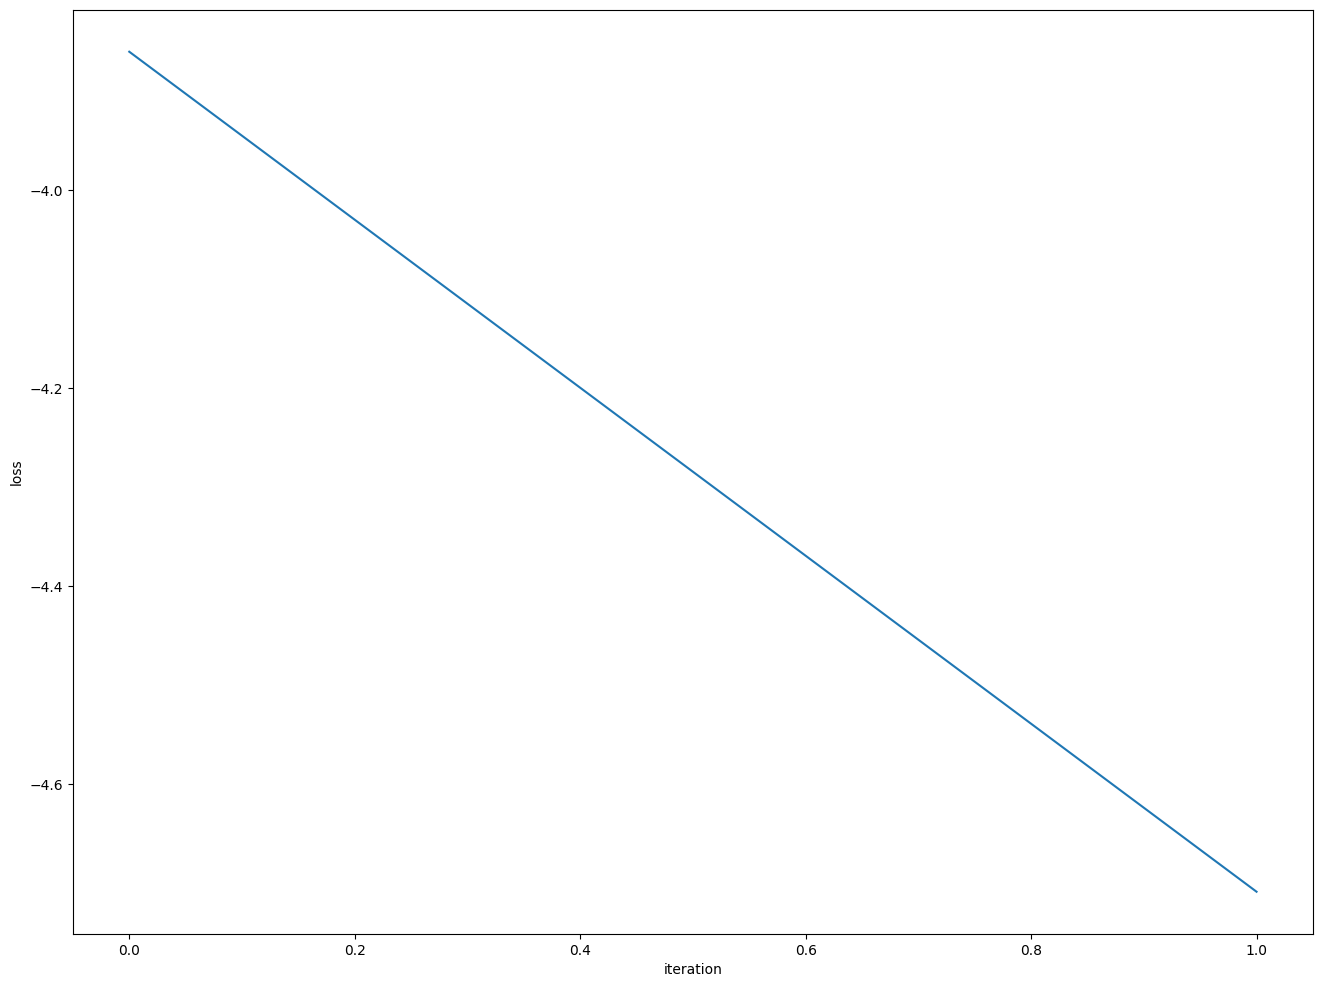

In [23]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


Text(0, 0.5, 'loss')

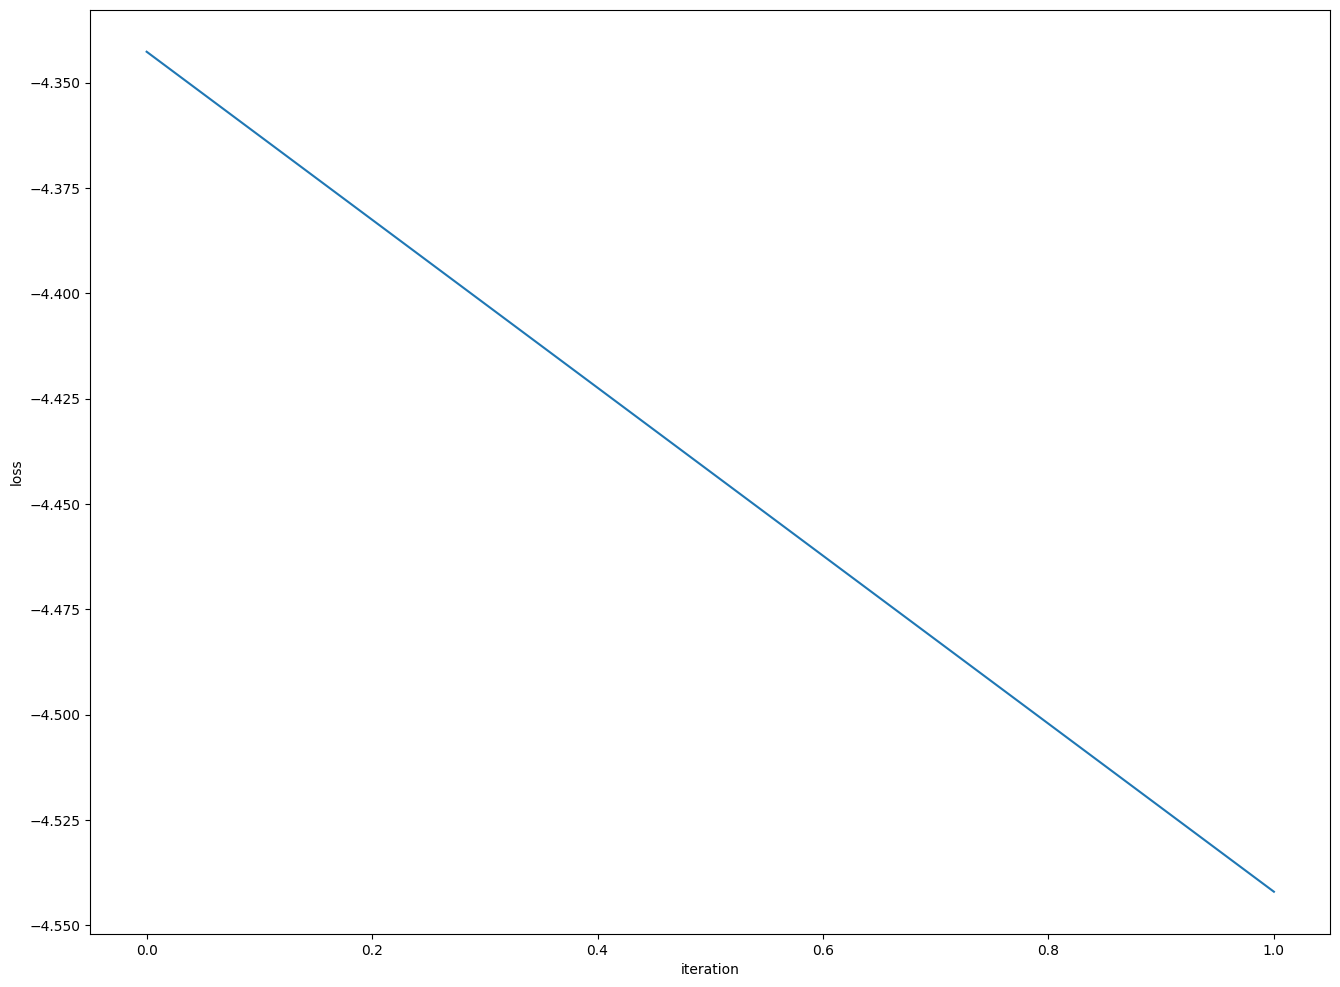

In [24]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [25]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [26]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.58333  validloss 0.82477±0.00000  bestvalidloss 0.82477  last_update 0
train: iter 1  trainloss 0.55204  validloss 0.64745±0.00000  bestvalidloss 0.64745  last_update 0
train: iter 2  trainloss 0.53756  validloss 0.63544±0.00000  bestvalidloss 0.63544  last_update 0
train: iter 3  trainloss 0.53716  validloss 0.62239±0.00000  bestvalidloss 0.62239  last_update 0
train: iter 4  trainloss 0.53151  validloss 0.62211±0.00000  bestvalidloss 0.62211  last_update 0
train: iter 5  trainloss 0.52469  validloss 0.61871±0.00000  bestvalidloss 0.61871  last_update 0
train: iter 6  trainloss 0.52126  validloss 0.62703±0.00000  bestvalidloss 0.61871  last_update 1
train: iter 7  trainloss 0.52224  validloss 0.62601±0.00000  bestvalidloss 0.61871  last_update 2
train: iter 8  trainloss 0.51517  validloss 0.61238±0.00000  bestvalidloss 0.61238  last_update 0
train: iter 9  trainloss 0.51576  validloss 0.61730±0.00000  bestvalidloss 0.61238  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.48394  validloss 0.58167±0.00000  bestvalidloss 0.58167  last_update 0
train: iter 84  trainloss 0.48784  validloss 0.59486±0.00000  bestvalidloss 0.58167  last_update 1
train: iter 85  trainloss 0.48564  validloss 0.59183±0.00000  bestvalidloss 0.58167  last_update 2
train: iter 86  trainloss 0.48276  validloss 0.60687±0.00000  bestvalidloss 0.58167  last_update 3
train: iter 87  trainloss 0.48569  validloss 0.59163±0.00000  bestvalidloss 0.58167  last_update 4
train: iter 88  trainloss 0.48676  validloss 0.58732±0.00000  bestvalidloss 0.58167  last_update 5
train: iter 89  trainloss 0.48263  validloss 0.59245±0.00000  bestvalidloss 0.58167  last_update 6
train: iter 90  trainloss 0.49307  validloss 0.59355±0.00000  bestvalidloss 0.58167  last_update 7
train: iter 91  trainloss 0.48412  validloss 0.59661±0.00000  bestvalidloss 0.58167  last_update 8
train: iter 92  trainloss 0.48793  validloss 0.61265±0.00000  bestvalidloss 0.58167  last_update 9
train: ite

train: iter 165  trainloss 0.47263  validloss 0.58168±0.00000  bestvalidloss 0.56627  last_update 13
train: iter 166  trainloss 0.47043  validloss 0.58021±0.00000  bestvalidloss 0.56627  last_update 14
train: iter 167  trainloss 0.47414  validloss 0.57342±0.00000  bestvalidloss 0.56627  last_update 15
train: iter 168  trainloss 0.48109  validloss 0.58010±0.00000  bestvalidloss 0.56627  last_update 16
train: iter 169  trainloss 0.47134  validloss 0.57570±0.00000  bestvalidloss 0.56627  last_update 17
train: iter 170  trainloss 0.47067  validloss 0.60680±0.00000  bestvalidloss 0.56627  last_update 18
train: iter 171  trainloss 0.46820  validloss 0.57259±0.00000  bestvalidloss 0.56627  last_update 19
train: iter 172  trainloss 0.47027  validloss 0.56272±0.00000  bestvalidloss 0.56272  last_update 0
train: iter 173  trainloss 0.46910  validloss 0.58645±0.00000  bestvalidloss 0.56272  last_update 1
train: iter 174  trainloss 0.46914  validloss 0.56136±0.00000  bestvalidloss 0.56136  last_up

train: iter 247  trainloss 0.46335  validloss 0.55646±0.00000  bestvalidloss 0.55248  last_update 3
train: iter 248  trainloss 0.46204  validloss 0.55693±0.00000  bestvalidloss 0.55248  last_update 4
train: iter 249  trainloss 0.46056  validloss 0.56312±0.00000  bestvalidloss 0.55248  last_update 5
train: iter 250  trainloss 0.46057  validloss 0.57363±0.00000  bestvalidloss 0.55248  last_update 6
train: iter 251  trainloss 0.45818  validloss 0.55763±0.00000  bestvalidloss 0.55248  last_update 7
train: iter 252  trainloss 0.45569  validloss 0.56097±0.00000  bestvalidloss 0.55248  last_update 8
train: iter 253  trainloss 0.46129  validloss 0.56703±0.00000  bestvalidloss 0.55248  last_update 9
train: iter 254  trainloss 0.46007  validloss 0.56651±0.00000  bestvalidloss 0.55248  last_update 10
train: iter 255  trainloss 0.45855  validloss 0.56203±0.00000  bestvalidloss 0.55248  last_update 11
train: iter 256  trainloss 0.46068  validloss 0.55866±0.00000  bestvalidloss 0.55248  last_update 

train: iter 329  trainloss 0.44635  validloss 0.54637±0.00000  bestvalidloss 0.54134  last_update 2
train: iter 330  trainloss 0.45647  validloss 0.54815±0.00000  bestvalidloss 0.54134  last_update 3
train: iter 331  trainloss 0.45050  validloss 0.54910±0.00000  bestvalidloss 0.54134  last_update 4
train: iter 332  trainloss 0.45434  validloss 0.56625±0.00000  bestvalidloss 0.54134  last_update 5
train: iter 333  trainloss 0.45302  validloss 0.54835±0.00000  bestvalidloss 0.54134  last_update 6
train: iter 334  trainloss 0.45405  validloss 0.54417±0.00000  bestvalidloss 0.54134  last_update 7
train: iter 335  trainloss 0.45034  validloss 0.54918±0.00000  bestvalidloss 0.54134  last_update 8
train: iter 336  trainloss 0.44872  validloss 0.55238±0.00000  bestvalidloss 0.54134  last_update 9
train: iter 337  trainloss 0.45031  validloss 0.54429±0.00000  bestvalidloss 0.54134  last_update 10
train: iter 338  trainloss 0.45015  validloss 0.54927±0.00000  bestvalidloss 0.54134  last_update 1

train: iter 411  trainloss 0.44379  validloss 0.55202±0.00000  bestvalidloss 0.52854  last_update 15
train: iter 412  trainloss 0.43840  validloss 0.53564±0.00000  bestvalidloss 0.52854  last_update 16
train: iter 413  trainloss 0.43892  validloss 0.53801±0.00000  bestvalidloss 0.52854  last_update 17
train: iter 414  trainloss 0.43929  validloss 0.53822±0.00000  bestvalidloss 0.52854  last_update 18
train: iter 415  trainloss 0.44160  validloss 0.52977±0.00000  bestvalidloss 0.52854  last_update 19
train: iter 416  trainloss 0.44182  validloss 0.53287±0.00000  bestvalidloss 0.52854  last_update 20
train: iter 417  trainloss 0.43979  validloss 0.54338±0.00000  bestvalidloss 0.52854  last_update 21
train: iter 418  trainloss 0.43694  validloss 0.54131±0.00000  bestvalidloss 0.52854  last_update 22
train: iter 419  trainloss 0.43784  validloss 0.54790±0.00000  bestvalidloss 0.52854  last_update 23
train: iter 420  trainloss 0.43819  validloss 0.54517±0.00000  bestvalidloss 0.52854  last_

train: iter 493  trainloss 0.43490  validloss 0.53994±0.00000  bestvalidloss 0.52626  last_update 8
train: iter 494  trainloss 0.43099  validloss 0.53822±0.00000  bestvalidloss 0.52626  last_update 9
train: iter 495  trainloss 0.43094  validloss 0.54457±0.00000  bestvalidloss 0.52626  last_update 10
train: iter 496  trainloss 0.43224  validloss 0.52668±0.00000  bestvalidloss 0.52626  last_update 11
train: iter 497  trainloss 0.42790  validloss 0.53631±0.00000  bestvalidloss 0.52626  last_update 12
train: iter 498  trainloss 0.43905  validloss 0.53048±0.00000  bestvalidloss 0.52626  last_update 13
train: iter 499  trainloss 0.43542  validloss 0.52892±0.00000  bestvalidloss 0.52626  last_update 14
train: iter 500  trainloss 0.43169  validloss 0.53314±0.00000  bestvalidloss 0.52626  last_update 15
train: iter 501  trainloss 0.43172  validloss 0.54338±0.00000  bestvalidloss 0.52626  last_update 16
train: iter 502  trainloss 0.43270  validloss 0.54271±0.00000  bestvalidloss 0.52626  last_up

train: iter 575  trainloss 0.42977  validloss 0.52859±0.00000  bestvalidloss 0.52348  last_update 57
train: iter 576  trainloss 0.42294  validloss 0.52707±0.00000  bestvalidloss 0.52348  last_update 58
train: iter 577  trainloss 0.42288  validloss 0.53097±0.00000  bestvalidloss 0.52348  last_update 59
train: iter 578  trainloss 0.42366  validloss 0.54057±0.00000  bestvalidloss 0.52348  last_update 60
train: iter 579  trainloss 0.42458  validloss 0.53178±0.00000  bestvalidloss 0.52348  last_update 61
train: iter 580  trainloss 0.42547  validloss 0.53434±0.00000  bestvalidloss 0.52348  last_update 62
train: iter 581  trainloss 0.42436  validloss 0.53865±0.00000  bestvalidloss 0.52348  last_update 63
train: iter 582  trainloss 0.42418  validloss 0.54264±0.00000  bestvalidloss 0.52348  last_update 64
train: iter 583  trainloss 0.42521  validloss 0.53367±0.00000  bestvalidloss 0.52348  last_update 65
train: iter 584  trainloss 0.41868  validloss 0.52973±0.00000  bestvalidloss 0.52348  last_

train: iter 657  trainloss 0.41350  validloss 0.53913±0.00000  bestvalidloss 0.52194  last_update 57
train: iter 658  trainloss 0.41392  validloss 0.54304±0.00000  bestvalidloss 0.52194  last_update 58
train: iter 659  trainloss 0.41689  validloss 0.53317±0.00000  bestvalidloss 0.52194  last_update 59
train: iter 660  trainloss 0.41854  validloss 0.53676±0.00000  bestvalidloss 0.52194  last_update 60
train: iter 661  trainloss 0.41363  validloss 0.54065±0.00000  bestvalidloss 0.52194  last_update 61
train: iter 662  trainloss 0.41644  validloss 0.52842±0.00000  bestvalidloss 0.52194  last_update 62
train: iter 663  trainloss 0.41581  validloss 0.53792±0.00000  bestvalidloss 0.52194  last_update 63
train: iter 664  trainloss 0.41759  validloss 0.53595±0.00000  bestvalidloss 0.52194  last_update 64
train: iter 665  trainloss 0.41305  validloss 0.52604±0.00000  bestvalidloss 0.52194  last_update 65
train: iter 666  trainloss 0.41767  validloss 0.53452±0.00000  bestvalidloss 0.52194  last_

train: iter 739  trainloss 0.40421  validloss 0.53254±0.00000  bestvalidloss 0.52039  last_update 9
train: iter 740  trainloss 0.41106  validloss 0.54037±0.00000  bestvalidloss 0.52039  last_update 10
train: iter 741  trainloss 0.41135  validloss 0.52948±0.00000  bestvalidloss 0.52039  last_update 11
train: iter 742  trainloss 0.41220  validloss 0.57901±0.00000  bestvalidloss 0.52039  last_update 12
train: iter 743  trainloss 0.41472  validloss 0.52745±0.00000  bestvalidloss 0.52039  last_update 13
train: iter 744  trainloss 0.40820  validloss 0.52510±0.00000  bestvalidloss 0.52039  last_update 14
train: iter 745  trainloss 0.41050  validloss 0.53000±0.00000  bestvalidloss 0.52039  last_update 15
train: iter 746  trainloss 0.41206  validloss 0.53276±0.00000  bestvalidloss 0.52039  last_update 16
train: iter 747  trainloss 0.40714  validloss 0.52969±0.00000  bestvalidloss 0.52039  last_update 17
train: iter 748  trainloss 0.40645  validloss 0.52889±0.00000  bestvalidloss 0.52039  last_u

train: iter 821  trainloss 0.40225  validloss 0.55838±0.00000  bestvalidloss 0.52039  last_update 91
train: iter 822  trainloss 0.40270  validloss 0.53599±0.00000  bestvalidloss 0.52039  last_update 92
train: iter 823  trainloss 0.39908  validloss 0.54030±0.00000  bestvalidloss 0.52039  last_update 93
train: iter 824  trainloss 0.39937  validloss 0.52999±0.00000  bestvalidloss 0.52039  last_update 94
train: iter 825  trainloss 0.39876  validloss 0.52519±0.00000  bestvalidloss 0.52039  last_update 95
train: iter 826  trainloss 0.39923  validloss 0.52811±0.00000  bestvalidloss 0.52039  last_update 96
train: iter 827  trainloss 0.40143  validloss 0.54326±0.00000  bestvalidloss 0.52039  last_update 97
train: iter 828  trainloss 0.40438  validloss 0.54652±0.00000  bestvalidloss 0.52039  last_update 98
train: iter 829  trainloss 0.40085  validloss 0.54617±0.00000  bestvalidloss 0.52039  last_update 99
train: iter 830  trainloss 0.40515  validloss 0.52426±0.00000  bestvalidloss 0.52039  last_

([0.5833314560353756,
  0.5520358419045805,
  0.5375594985671341,
  0.5371578332036734,
  0.5315118932165206,
  0.5246900872327387,
  0.5212622640654445,
  0.5222411843016743,
  0.5151672981679439,
  0.5157648412510752,
  0.5214394918642938,
  0.5135145373642445,
  0.5103861801326275,
  0.5143788434565068,
  0.5129777074791491,
  0.5096085200086236,
  0.5020308816805482,
  0.5125375392846763,
  0.5134274891577661,
  0.5053164275363088,
  0.5041993467137218,
  0.5058531718328595,
  0.5109031052328646,
  0.5036880984902382,
  0.5020861206576228,
  0.5021628924645484,
  0.500556611828506,
  0.5060332909226417,
  0.5103512818925082,
  0.5002174872905016,
  0.499322859197855,
  0.5032715326175093,
  0.5036011246964336,
  0.5008600184693932,
  0.5025480786338449,
  0.5006261693313718,
  0.5024008549749851,
  0.4969415276311338,
  0.5033737012185157,
  0.5000194850377738,
  0.5008706429973244,
  0.4936526528559625,
  0.5005772050470114,
  0.49786628875881433,
  0.4929458159022033,
  0.5026995

In [27]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.824095173603295
valid_loss:  -9.491858790993692
weight_alpha 1.0 h_min_tilde -12.323021 ell_tilde -7.357647897081375 kappa_tilde 0.0004487702503352868
train_loss:  -4.6662718762874595
valid_loss:  -4.285665644073487
weight_alpha 0.2 h_min_tilde -12.323021 ell_tilde -4.590150629844665 kappa_tilde 0.0003596082419257058


In [28]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -910.74751  validloss -857.41753±0.00000  bestvalidloss -857.41753  last_update 0
train: iter 1  trainloss -919.65777  validloss -830.22509±0.00000  bestvalidloss -857.41753  last_update 1
train: iter 2  trainloss -923.76885  validloss -851.33202±0.00000  bestvalidloss -857.41753  last_update 2
train: iter 3  trainloss -930.69424  validloss -847.08455±0.00000  bestvalidloss -857.41753  last_update 3
train: iter 4  trainloss -905.62517  validloss -780.20241±0.00000  bestvalidloss -857.41753  last_update 4
train: iter 5  trainloss -914.31576  validloss -840.20190±0.00000  bestvalidloss -857.41753  last_update 5
train: iter 6  trainloss -929.41241  validloss -842.34998±0.00000  bestvalidloss -857.41753  last_update 6
train: iter 7  trainloss -926.32715  validloss -848.84490±0.00000  bestvalidloss -857.41753  last_update 7
train: iter 8  trainloss -915.42418  validloss -835.17364±0.00000  bestvalidloss -857.41753  last_u

train: iter 76  trainloss -936.62292  validloss -855.75796±0.00000  bestvalidloss -870.10033  last_update 44
train: iter 77  trainloss -921.88199  validloss -861.33663±0.00000  bestvalidloss -870.10033  last_update 45
train: iter 78  trainloss -919.17550  validloss -832.42043±0.00000  bestvalidloss -870.10033  last_update 46
train: iter 79  trainloss -904.76564  validloss -794.12164±0.00000  bestvalidloss -870.10033  last_update 47
train: iter 80  trainloss -928.12433  validloss -838.32617±0.00000  bestvalidloss -870.10033  last_update 48
train: iter 81  trainloss -923.29813  validloss -832.76494±0.00000  bestvalidloss -870.10033  last_update 49
train: iter 82  trainloss -928.95795  validloss -856.95850±0.00000  bestvalidloss -870.10033  last_update 50
train: iter 83  trainloss -928.89887  validloss -854.94949±0.00000  bestvalidloss -870.10033  last_update 51
train: iter 84  trainloss -934.48477  validloss -858.27440±0.00000  bestvalidloss -870.10033  last_update 52
train: iter 85  tra

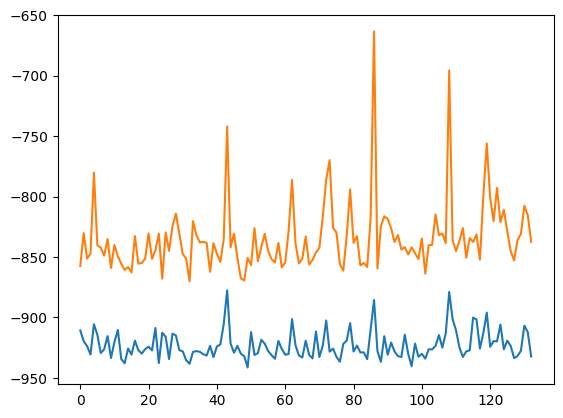

alpha 0.2 default_lr 0.0005


In [29]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [30]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [31]:
print(datetime.datetime.now())

2023-06-04 09:01:08.068902


# 評価関数計算

In [32]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [33]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.51206  validloss 0.70277±0.00000  bestvalidloss 0.70277  last_update 0
train: iter 1  trainloss 0.49496  validloss 0.63238±0.00000  bestvalidloss 0.63238  last_update 0
train: iter 2  trainloss 0.48561  validloss 0.61273±0.00000  bestvalidloss 0.61273  last_update 0
train: iter 3  trainloss 0.48251  validloss 0.61685±0.00000  bestvalidloss 0.61273  last_update 1
train: iter 4  trainloss 0.48236  validloss 0.64481±0.00000  bestvalidloss 0.61273  last_update 2
train: iter 5  trainloss 0.47468  validloss 0.60262±0.00000  bestvalidloss 0.60262  last_update 0
train: iter 6  trainloss 0.47339  validloss 0.61593±0.00000  bestvalidloss 0.60262  last_update 1
train: iter 7  trainloss 0.47394  validloss 0.59699±0.00000  bestvalidloss 0.59699  last_update 0
train: iter 8  trainloss 0.47288  validloss 0.61976±0.00000  bestvalidloss 0.59699  last_update 1
train: iter 9  trainloss 0.46957  validloss 0.59797±0.00000  bestvalidloss 0.59699  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.43768  validloss 0.62031±0.00000  bestvalidloss 0.57013  last_update 7
train: iter 84  trainloss 0.44517  validloss 0.58558±0.00000  bestvalidloss 0.57013  last_update 8
train: iter 85  trainloss 0.43984  validloss 0.59338±0.00000  bestvalidloss 0.57013  last_update 9
train: iter 86  trainloss 0.43863  validloss 0.60238±0.00000  bestvalidloss 0.57013  last_update 10
train: iter 87  trainloss 0.43798  validloss 0.58220±0.00000  bestvalidloss 0.57013  last_update 11
train: iter 88  trainloss 0.43816  validloss 0.58176±0.00000  bestvalidloss 0.57013  last_update 12
train: iter 89  trainloss 0.44147  validloss 0.58138±0.00000  bestvalidloss 0.57013  last_update 13
train: iter 90  trainloss 0.43972  validloss 0.61855±0.00000  bestvalidloss 0.57013  last_update 14
train: iter 91  trainloss 0.44198  validloss 0.58902±0.00000  bestvalidloss 0.57013  last_update 15
train: iter 92  trainloss 0.44001  validloss 0.58689±0.00000  bestvalidloss 0.57013  last_update 16
tra

train: iter 165  trainloss 0.42789  validloss 0.58735±0.00000  bestvalidloss 0.56788  last_update 59
train: iter 166  trainloss 0.42821  validloss 0.59004±0.00000  bestvalidloss 0.56788  last_update 60
train: iter 167  trainloss 0.42946  validloss 0.60668±0.00000  bestvalidloss 0.56788  last_update 61
train: iter 168  trainloss 0.43030  validloss 0.58693±0.00000  bestvalidloss 0.56788  last_update 62
train: iter 169  trainloss 0.43767  validloss 0.58348±0.00000  bestvalidloss 0.56788  last_update 63
train: iter 170  trainloss 0.43026  validloss 0.58243±0.00000  bestvalidloss 0.56788  last_update 64
train: iter 171  trainloss 0.42622  validloss 0.60362±0.00000  bestvalidloss 0.56788  last_update 65
train: iter 172  trainloss 0.42643  validloss 0.58606±0.00000  bestvalidloss 0.56788  last_update 66
train: iter 173  trainloss 0.42965  validloss 0.56940±0.00000  bestvalidloss 0.56788  last_update 67
train: iter 174  trainloss 0.43044  validloss 0.57344±0.00000  bestvalidloss 0.56788  last_

([0.5120608944445848,
  0.4949574420228601,
  0.4856068960390985,
  0.48250823924317954,
  0.4823550169356167,
  0.47467690566554666,
  0.4733852809295058,
  0.4739405846223235,
  0.4728816347196698,
  0.4695684932172298,
  0.46862403871491554,
  0.477296104375273,
  0.4671793455258012,
  0.46877860855311154,
  0.4624311126768589,
  0.46813727244734765,
  0.4645265845581889,
  0.4608518786728382,
  0.4598297508433461,
  0.46353089325129987,
  0.4561876988969743,
  0.46377665679901836,
  0.4567704176530242,
  0.45673948237672446,
  0.4595525538548827,
  0.4537320579402149,
  0.45872255340218543,
  0.4590657502412796,
  0.4568153493106365,
  0.4543173838406801,
  0.456030729226768,
  0.45215858444571494,
  0.45427947454154494,
  0.4615547614172101,
  0.45076642828062174,
  0.45127985132858156,
  0.4578226593323052,
  0.4545695778913796,
  0.4491768378764391,
  0.4494819642044604,
  0.45123968068510295,
  0.44964292040094733,
  0.4508833922445774,
  0.454550077021122,
  0.4522025927901268

In [34]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.525121924173831
valid_loss:  -8.401877243506906
weight_alpha 1.0 h_min_tilde -12.323088 ell_tilde -6.100472988040447 kappa_tilde 0.00040087921984573193
train_loss:  -4.451783718967438
valid_loss:  -4.025027409362792
weight_alpha 0.2 h_min_tilde -12.323088 ell_tilde -4.366432457046509 kappa_tilde 0.00035451509334528036


In [35]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 14.85294  validloss 19.77132±0.00000  bestvalidloss 19.77132  last_update 0
train: iter 1  trainloss 8.84796  validloss 12.00517±0.00000  bestvalidloss 12.00517  last_update 0
train: iter 2  trainloss 4.80233  validloss 6.80647±0.00000  bestvalidloss 6.80647  last_update 0
train: iter 3  trainloss 2.41342  validloss 3.50441±0.00000  bestvalidloss 3.50441  last_update 0
train: iter 4  trainloss 0.67997  validloss 1.75017±0.00000  bestvalidloss 1.75017  last_update 0
train: iter 5  trainloss -0.28358  validloss 0.26743±0.00000  bestvalidloss 0.26743  last_update 0
train: iter 6  trainloss -0.99009  validloss -0.56644±0.00000  bestvalidloss -0.56644  last_update 0
train: iter 7  trainloss -1.49329  validloss -1.06401±0.00000  bestvalidloss -1.06401  last_update 0
train: iter 8  trainloss -1.64471  validloss -1.51543±0.00000  bestvalidloss -1.51543  last_update 0
train: iter 9  trainloss -1.76432  validloss -1.66537±0.00000  bestvalidloss -1.66537  last_update 0
tr

train: iter 88  trainloss -1.92892  validloss -2.18032±0.00000  bestvalidloss -2.20640  last_update 56
train: iter 89  trainloss -1.96970  validloss -2.17029±0.00000  bestvalidloss -2.20640  last_update 57
train: iter 90  trainloss -1.95182  validloss -2.03035±0.00000  bestvalidloss -2.20640  last_update 58
train: iter 91  trainloss -2.00753  validloss -2.09672±0.00000  bestvalidloss -2.20640  last_update 59
train: iter 92  trainloss -1.96613  validloss -2.10728±0.00000  bestvalidloss -2.20640  last_update 60
train: iter 93  trainloss -1.95363  validloss -2.00468±0.00000  bestvalidloss -2.20640  last_update 61
train: iter 94  trainloss -1.92587  validloss -2.05999±0.00000  bestvalidloss -2.20640  last_update 62
train: iter 95  trainloss -2.01233  validloss -2.13427±0.00000  bestvalidloss -2.20640  last_update 63
train: iter 96  trainloss -1.94880  validloss -2.02272±0.00000  bestvalidloss -2.20640  last_update 64
train: iter 97  trainloss -2.00408  validloss -2.12159±0.00000  bestvalid

train: iter 178  trainloss -1.95131  validloss -2.17508±0.00000  bestvalidloss -2.23714  last_update 49
train: iter 179  trainloss -1.91822  validloss -2.01025±0.00000  bestvalidloss -2.23714  last_update 50
train: iter 180  trainloss -1.98932  validloss -2.05611±0.00000  bestvalidloss -2.23714  last_update 51
train: iter 181  trainloss -1.92812  validloss -2.06165±0.00000  bestvalidloss -2.23714  last_update 52
train: iter 182  trainloss -1.96201  validloss -2.02532±0.00000  bestvalidloss -2.23714  last_update 53
train: iter 183  trainloss -1.97820  validloss -2.12379±0.00000  bestvalidloss -2.23714  last_update 54
train: iter 184  trainloss -1.94730  validloss -1.99626±0.00000  bestvalidloss -2.23714  last_update 55
train: iter 185  trainloss -1.96546  validloss -2.09377±0.00000  bestvalidloss -2.23714  last_update 56
train: iter 186  trainloss -1.89190  validloss -2.13565±0.00000  bestvalidloss -2.23714  last_update 57
train: iter 187  trainloss -2.03921  validloss -2.09829±0.00000 

In [36]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.8892, -1.7900, -4.3318, -5.2446], requires_grad=True)


In [37]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 2.57331  validloss 5.43726±0.00000  bestvalidloss 5.43726  last_update 0
train: iter 1  trainloss 2.64111  validloss 4.75113±0.00000  bestvalidloss 4.75113  last_update 0
train: iter 2  trainloss 2.51686  validloss 4.49224±0.00000  bestvalidloss 4.49224  last_update 0
train: iter 3  trainloss 2.57017  validloss 4.79825±0.00000  bestvalidloss 4.49224  last_update 1
train: iter 4  trainloss 2.58652  validloss 4.66264±0.00000  bestvalidloss 4.49224  last_update 2
train: iter 5  trainloss 2.51818  validloss 4.72768±0.00000  bestvalidloss 4.49224  last_update 3
train: iter 6  trainloss 2.55394  validloss 4.81675±0.00000  bestvalidloss 4.49224  last_update 4
train: iter 7  trainloss 2.56366  validloss 4.41454±0.00000  bestvalidloss 4.41454  last_update 0
train: iter 8  trainloss 2.56467  validloss 4.69526±0.00000  bestvalidloss 4.41454  last_update 1
train: iter 9  trainloss 2.60082  validloss 4.64680±0.00000  bestvalidloss 4.41454  last_update 2
train: iter 10  trai

train: iter 83  trainloss 2.54278  validloss 5.09852±0.00000  bestvalidloss 4.19853  last_update 28
train: iter 84  trainloss 2.46735  validloss 4.51943±0.00000  bestvalidloss 4.19853  last_update 29
train: iter 85  trainloss 2.59270  validloss 4.65096±0.00000  bestvalidloss 4.19853  last_update 30
train: iter 86  trainloss 2.63558  validloss 4.70814±0.00000  bestvalidloss 4.19853  last_update 31
train: iter 87  trainloss 2.50906  validloss 4.36092±0.00000  bestvalidloss 4.19853  last_update 32
train: iter 88  trainloss 2.52401  validloss 4.94911±0.00000  bestvalidloss 4.19853  last_update 33
train: iter 89  trainloss 2.63594  validloss 4.58693±0.00000  bestvalidloss 4.19853  last_update 34
train: iter 90  trainloss 2.55396  validloss 4.89511±0.00000  bestvalidloss 4.19853  last_update 35
train: iter 91  trainloss 2.47248  validloss 4.82696±0.00000  bestvalidloss 4.19853  last_update 36
train: iter 92  trainloss 2.54345  validloss 4.73125±0.00000  bestvalidloss 4.19853  last_update 37


train: iter 166  trainloss 2.50578  validloss 4.51126±0.00000  bestvalidloss 4.18970  last_update 34
train: iter 167  trainloss 2.54856  validloss 4.79138±0.00000  bestvalidloss 4.18970  last_update 35
train: iter 168  trainloss 2.62434  validloss 4.78143±0.00000  bestvalidloss 4.18970  last_update 36
train: iter 169  trainloss 2.59364  validloss 4.71387±0.00000  bestvalidloss 4.18970  last_update 37
train: iter 170  trainloss 2.61166  validloss 4.30556±0.00000  bestvalidloss 4.18970  last_update 38
train: iter 171  trainloss 2.47173  validloss 5.04205±0.00000  bestvalidloss 4.18970  last_update 39
train: iter 172  trainloss 2.61436  validloss 4.50988±0.00000  bestvalidloss 4.18970  last_update 40
train: iter 173  trainloss 2.55674  validloss 4.81839±0.00000  bestvalidloss 4.18970  last_update 41
train: iter 174  trainloss 2.52656  validloss 4.80894±0.00000  bestvalidloss 4.18970  last_update 42
train: iter 175  trainloss 2.58729  validloss 4.68902±0.00000  bestvalidloss 4.18970  last_

In [38]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-12.2556)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(5.8677)


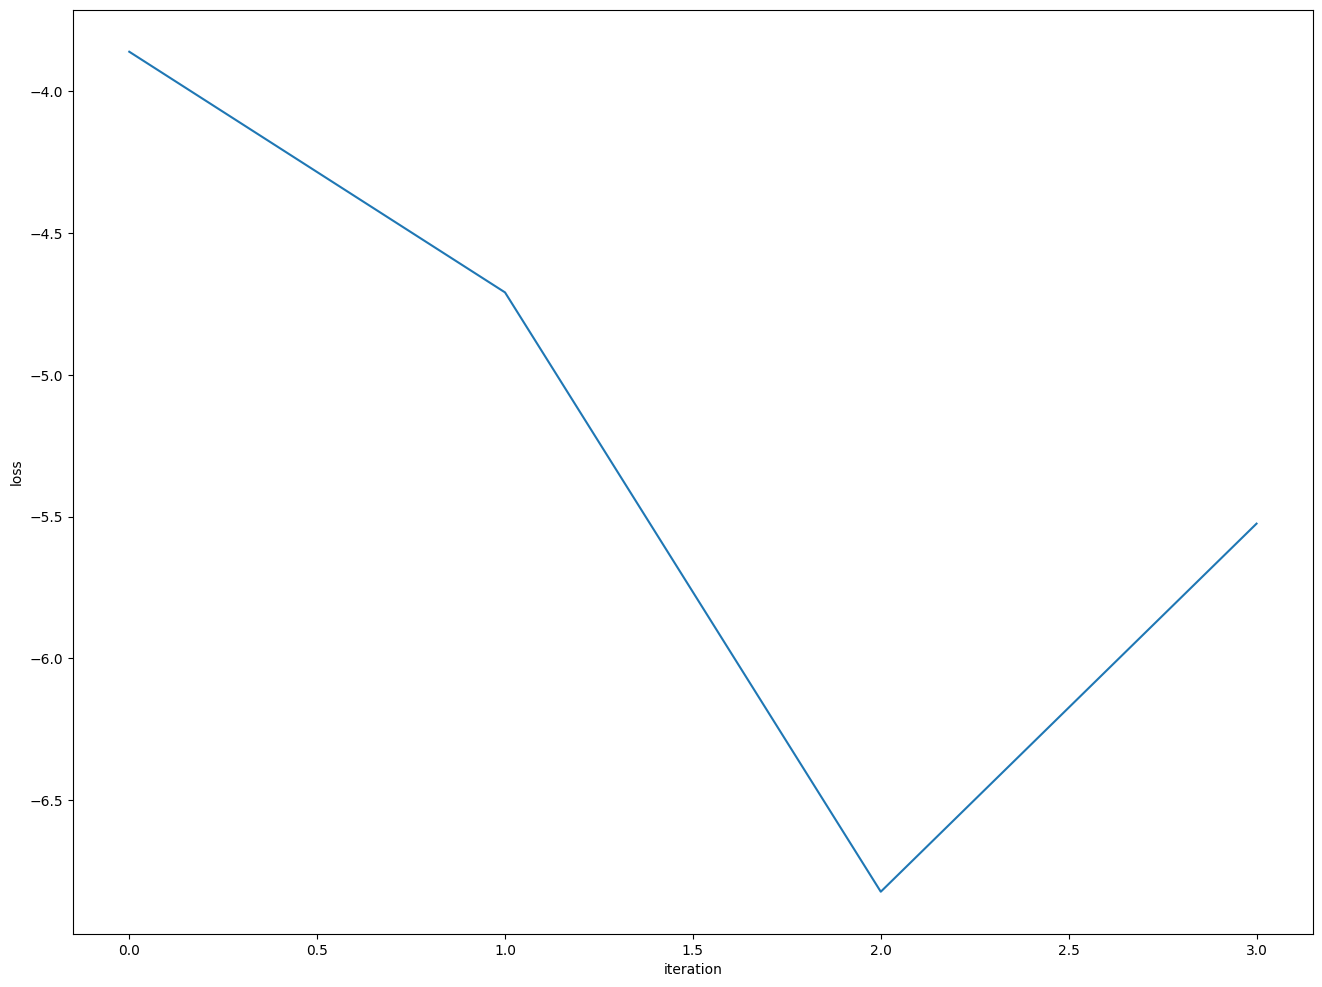

In [39]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

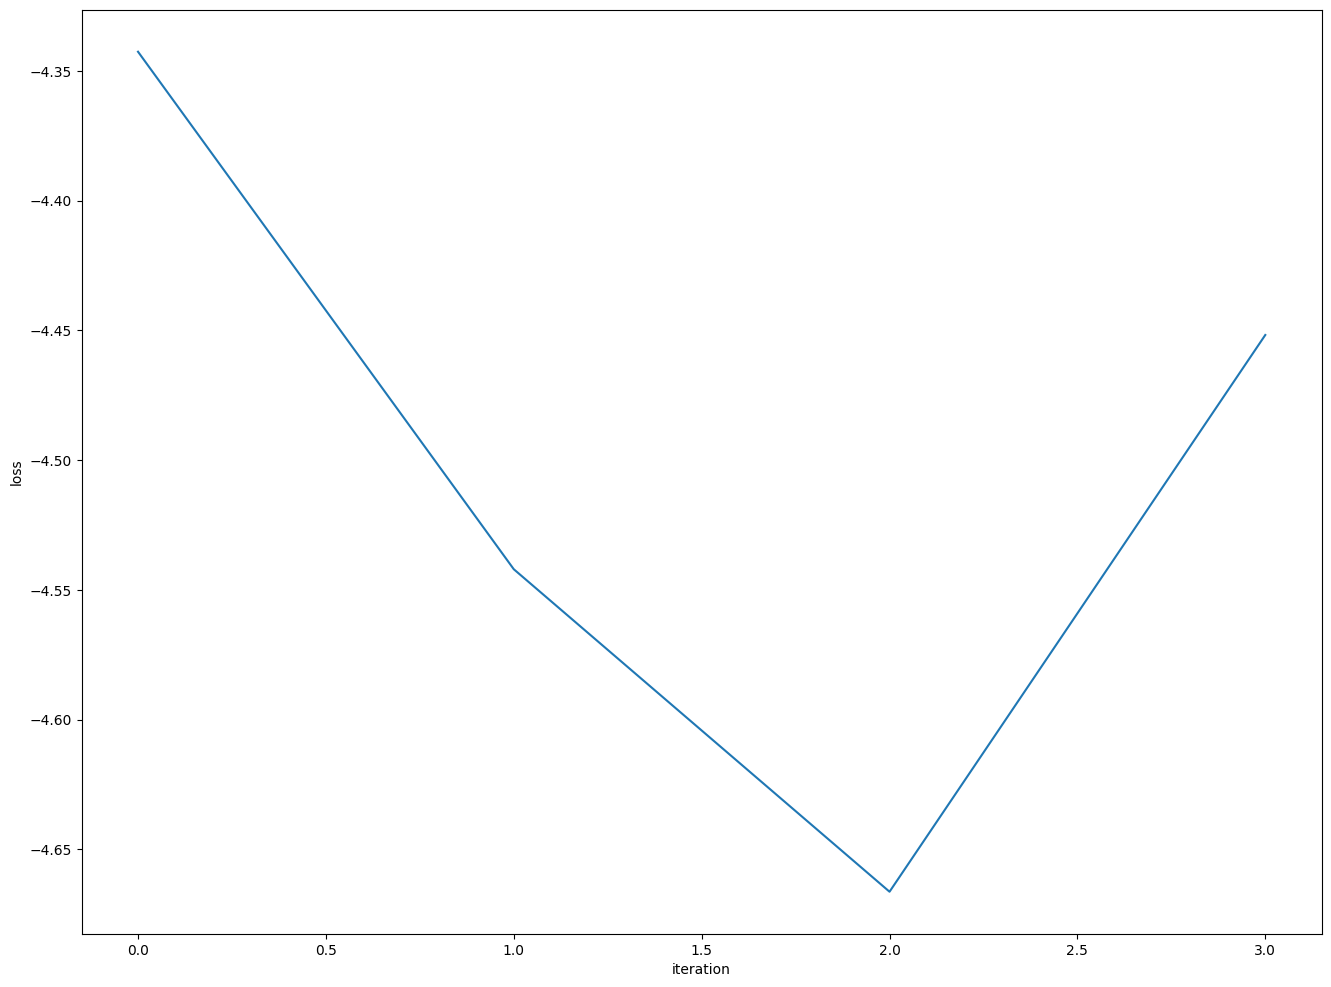

In [40]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")